In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch
import pandas as pd
import os

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils
import seaborn as sns

In [2]:
def flatten(in_dict):
    out_dict = {}
    for k, v in in_dict.items():
        if isinstance(v, dict):
            v_flat = flatten(v)
            out_dict.update({k+"."+v_k: v_v for v_k, v_v in v_flat.items()})
        else:
            out_dict[k] = v
    return out_dict

In [3]:

base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_52_cifar10_cycles")

series_list = []

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir"]:
        continue
    if not os.path.exists(base_log_dir/run/"samples.pt"):
        continue
    try:
        with open(base_log_dir/run/"run.json") as f:
            s2 = pd.Series(flatten(json.load(f)))
        with open(base_log_dir/run/"config.json") as f:
            s1 = pd.Series(flatten(json.load(f)))

        s2["the_dir"] = base_log_dir/run
        series_list.append(pd.concat([s1, s2]))
    except json.JSONDecodeError as e:
        print(run, e)
    except FileNotFoundError as e:
        print(run, e)
        
    
full_df = pd.DataFrame(series_list)
full_df[["status", "lr", "temperature", "weight_prior", "inference", "log_dir", "load_samples"]]

7 Expecting value: line 1 column 1 (char 0)


,status,lr,temperature,weight_prior,inference,log_dir,load_samples
0,RUNNING,0.01,0.00,NaN,NaN,NaN,NaN
1,COMPLETED,0.01,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN
2,COMPLETED,0.01,0.10,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN
3,RUNNING,0.01,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN
4,RUNNING,0.01,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN
5,RUNNING,0.01,0.00,NaN,NaN,NaN,NaN
6,RUNNING,0.01,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN
7,RUNNING,0.01,0.10,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN


In [22]:
full_df = full_df[full_df["status"] != "FAILED"]
full_df[["status", "model", "temperature", "weight_prior", "inference", "the_dir", "load_samples", "sampling_decay"]]

,status,model,temperature,weight_prior,inference,the_dir,load_samples,sampling_decay
0,RUNNING,googleresnet,0.00,NaN,NaN,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,flat
1,COMPLETED,googleresnet,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine
2,COMPLETED,googleresnet,0.10,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine
3,RUNNING,googleresnet,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine
4,RUNNING,resnet18,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine
5,RUNNING,resnet18,0.00,NaN,NaN,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,flat
6,RUNNING,resnet18,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine
7,RUNNING,resnet18,0.10,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_52_...,NaN,cosine


## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [23]:
with open(Path(full_df.iloc[4, :]["the_dir"])/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                               "model",
                               "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                               "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                               "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")
config["temperature"]

Loaded model of kind resnet18


1.0

In [24]:
config["temperature"], config["lr"]

(1.0, 0.01)

In [25]:
sizes2 = plot.get_sizes(model)


In [26]:
sizes.update(sizes2)
sizes

{'net.module.0.weight_prior.p': 432,
 'net.module.0.weight_prior.loc': 1,
 'net.module.0.weight_prior.scale': 1,
 'net.module.1.weight': 16,
 'net.module.1.bias': 16,
 'net.module.1.running_mean': 16,
 'net.module.1.running_var': 16,
 'net.module.1.num_batches_tracked': 1,
 'net.module.3.main.0.weight_prior.p': 2304,
 'net.module.3.main.0.weight_prior.loc': 1,
 'net.module.3.main.0.weight_prior.scale': 1,
 'net.module.3.main.1.weight': 16,
 'net.module.3.main.1.bias': 16,
 'net.module.3.main.1.running_mean': 16,
 'net.module.3.main.1.running_var': 16,
 'net.module.3.main.1.num_batches_tracked': 1,
 'net.module.3.main.3.weight_prior.p': 2304,
 'net.module.3.main.3.weight_prior.loc': 1,
 'net.module.3.main.3.weight_prior.scale': 1,
 'net.module.3.main.4.weight': 16,
 'net.module.3.main.4.bias': 16,
 'net.module.3.main.4.running_mean': 16,
 'net.module.3.main.4.running_var': 16,
 'net.module.3.main.4.num_batches_tracked': 1,
 'net.module.4.main.0.weight_prior.p': 2304,
 'net.module.4.main

## Plot metrics

First we load the metrics, then we plot various aspects of them.

In [11]:
full_df.loc[[23, 37], ["the_dir"]].values

array([[PosixPath('/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/43')],
       [PosixPath('/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/85')]],
      dtype=object)

In [12]:
full_df[["inference", "temperature", "lr", "momentum"]].sort_values(by=["inference", "temperature", "lr", "momentum"])

,inference,temperature,lr,momentum
2,HMCReject,1.0,0.000001,1.00
9,HMCReject,1.0,0.000001,1.00
29,HMCReject,1.0,0.000100,1.00
71,HMCReject,1.0,0.000100,1.00
34,HMCReject,1.0,0.001000,1.00
...,...,...,...,...
57,NaN,0.0,0.100000,0.00
13,NaN,0.0,0.100000,0.90
30,NaN,0.0,0.100000,0.90
21,NaN,0.0,0.100000,0.98


[0.86 0.87 0.88 0.88 0.88 0.88 0.86 0.89 0.88 0.91 0.86 0.88 0.87 0.87
 0.88 0.88 0.87 0.89 0.88 0.89 0.88 0.89 0.89 0.88 0.87 0.88 0.88 0.89
 0.89 0.88 0.89 0.89 0.89 0.87 0.87 0.87 0.88 0.88 0.87 0.88 0.89 0.88
 0.88 0.87 0.89 0.88 0.86 0.88 0.87 0.88]


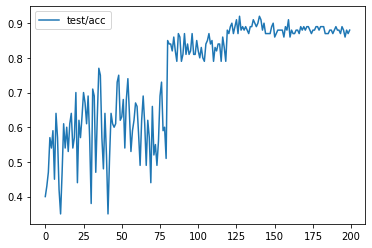

In [53]:

with h5py.File("/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/81/metrics.h5", 'r', swmr=True) as metrics:
    plot.metric(plt, metrics, "test/acc", mask=slice(None), legend=True)
    print(metrics["test/acc"][-50:])

In [6]:
next(iter(full_df.iterrows()))



(0,
 lr                               0.01
 momentum                     0.993632
 model                    googleresnet
 data                cifar10_augmented
 width                              16
                           ...        
 result.lp_std                     NaN
 result.lp_stderr                  NaN
 start_time                        NaN
 stop_time                         NaN
 result                            NaN
 Name: 0, Length: 91, dtype: object)

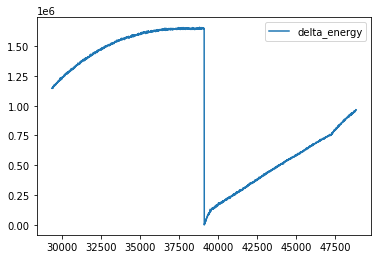

In [18]:
with h5py.File(Path(log_dir, "metrics.h5"), "r", swmr=True) as metrics:
    plot.metric(plt, metrics, "delta_energy", slice(3000, 5000))

t=0.0 model=googleresnet Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')
t=0.0 model=resnet18 0.9314


/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:229: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


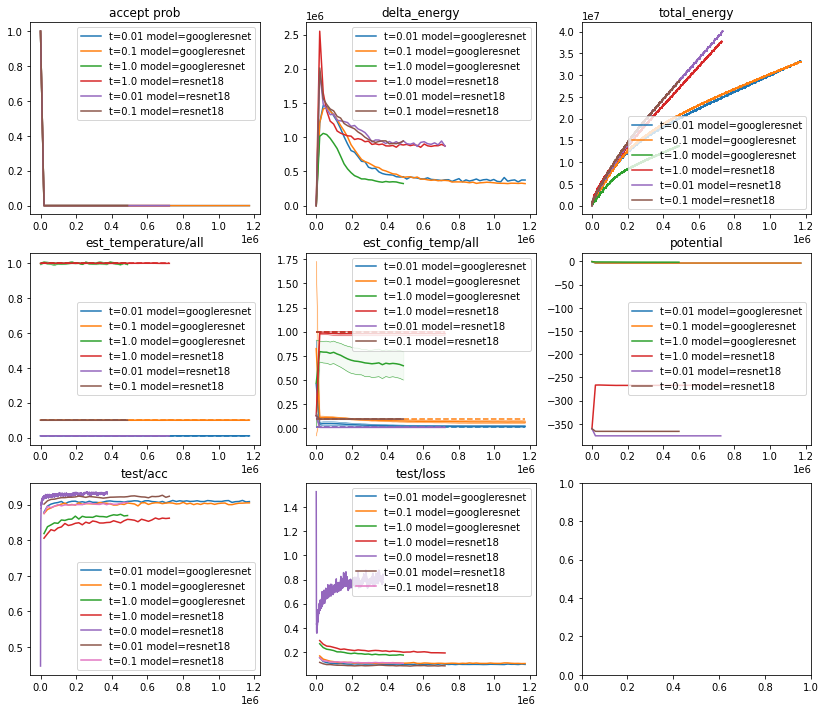

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12), facecolor='white')


temperature = 1.0
lr = 0.01

def accept_prob(x):
    return np.exp(np.minimum(0., -x/temperature))


df = full_df[(full_df["lr"] == lr) 
             & (full_df["temperature"] == temperature)]

sgd_df = full_df[(full_df["lr"] == lr)
                & (full_df["temperature"] == 0.0 )]

for _, series in full_df.iterrows():
    
    log_dir = series["the_dir"]
    temperature = series["temperature"]
    lr=series["lr"]
    label=f"t={temperature} model={series['model']}"
    plot_kwargs = dict(label=label)
    try:
        metrics = h5py.File(Path(log_dir, "metrics.h5"), "r", swmr=True)
        if "acceptance" in metrics:
            is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        else:
            is_sample_mask = slice(None)
        if "delta_energy" in metrics:
            ax = axes[0, 0]
            plot.metric(ax, metrics, "delta_energy", transform=accept_prob,
                        plot_kwargs=plot_kwargs, mask=is_sample_mask, legend=True)
            ax.set_title("accept prob")

            ax = axes[0, 1]
            plot.metric(ax, metrics, "delta_energy", mask=is_sample_mask, ewma_alpha=0.0, iqr_ylim=None,
                       plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("delta_energy")

            #plot.vlines(axes[1], metrics, is_sample_mask)
            ax = axes[0, 2]
            plot.metric(ax, metrics, "total_energy", mask=slice(None), iqr_ylim=None, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("total_energy")
        if "est_temperature" in metrics:
            ax = axes[1, 0]
            plot.temperature_stderr(ax, metrics, "est_temperature", sizes, mask=is_sample_mask, legend=True, label=label)
            ax.set_title("est_temperature/all")

            ax = axes[1, 1]
            plot.temperature_stderr(ax, metrics, "est_config_temp", sizes, mask=is_sample_mask, legend=True, label=label)
            ax.set_title("est_config_temp/all")


            ax = axes[1, 2]
            plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("potential")
        
            ax = axes[2, 0]
            plot.metric(ax, metrics, "test/acc", mask=is_sample_mask, plot_kwargs=dict(label=label), legend=True)
            ax.set_title("test/acc")

            ax = axes[2, 1]
            plot.metric(ax, metrics, "test/loss", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("test/loss")
        else:
            ax = axes[2, 0]
            ax.plot(metrics["steps"][:] * 125, metrics["test/acc"][:],  label=label)
            ax.set_title("test/acc")
            print(label, metrics["test/acc"][-10:].mean())
            
            ax = axes[2, 1]
            ax.plot(metrics["steps"][:] * 125, metrics["test/loss"][:], label=label)
            ax.set_title("test/loss")

    except OSError as e:
        print(label, e)
    finally:
        if "metrics" in locals():
            metrics.close()

axes[2, 1].legend()
axes[2, 0].legend()
                
#axes[0, 1].set_ylim(-10, 40000)
#axes[0, 2].set_ylim(-10, 10000000)
#if temperature == 1.0:
#    axes[1, 0].set_ylim(0.975, 1.025)
#    axes[1, 1].set_ylim(0.975, 1.025)
#elif temperature == 0.01:
#    axes[1, 0].set_ylim(0.005, 0.02)
#    axes[1, 1].set_ylim(0.004, 0.02)
#axes[2, 0].set_ylim((0.75, 1.0))

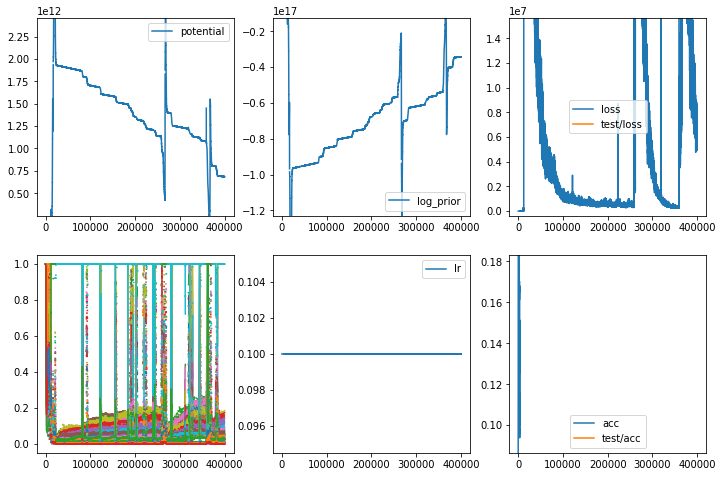

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

mask = slice(None)

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2., mask=mask)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2., mask=mask)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=mask, iqr_ylim=2.)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, mask=mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr', mask=mask)

plot.metric(axes[1, 2], metrics, 'acc', mask=mask, iqr_ylim=2., ewma_alpha=0.9)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=mask, iqr_ylim=2.)

In [14]:
"average acceptance", 1-np.mean(metrics["acceptance/rejected"][mask])

('average acceptance', 9.178023947533842e+18)

In [16]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)


## Load and poke the model

In [17]:
del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *remove* .module. from the key
    for k in list(state_dict_samples.keys()):
        if k.startswith("net.module."):
            state_dict_samples["net." + k.lstrip("net.module.")] = state_dict_samples[k]
            del state_dict_samples[k]

In [18]:
model.load_state_dict({k: v[-1] for k, v in state_dict_samples.items()})

<All keys matched successfully>